Generating dataset 1 with mean=0, variance=2 and mean_c=1, variance_c=1


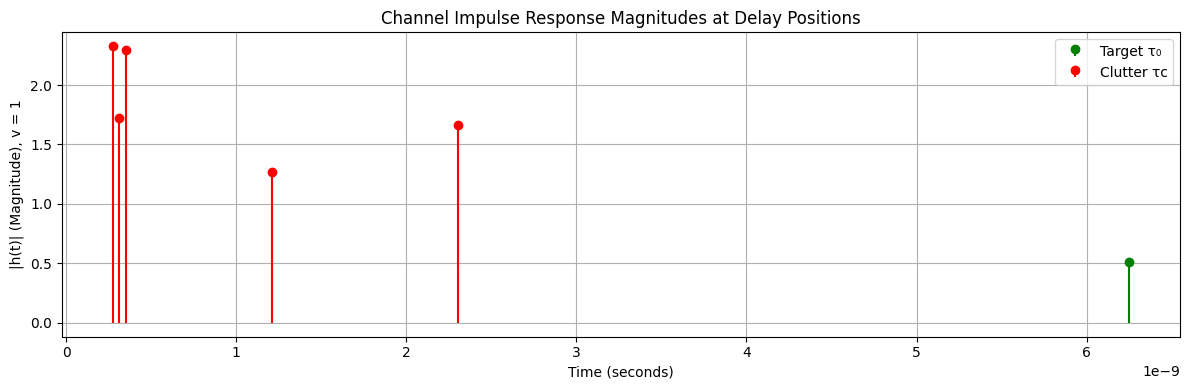

round# : 1  v :  1  tau: 4.281757836103628e-11  min_delay_sec:  5 0.2 [0.80592844] [1.9886655892963088, 1.0639865806255047, 1.420025029694856, 3.0100650581313215, 2.369470779918953]


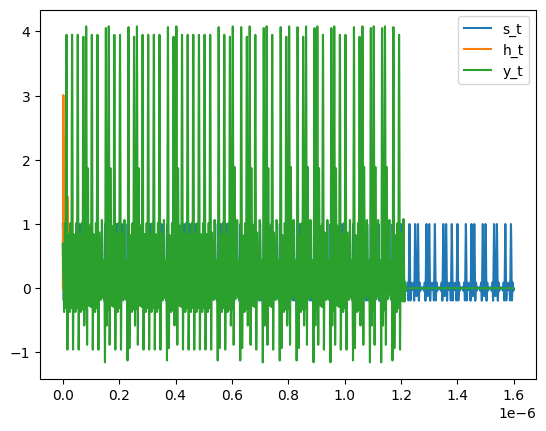

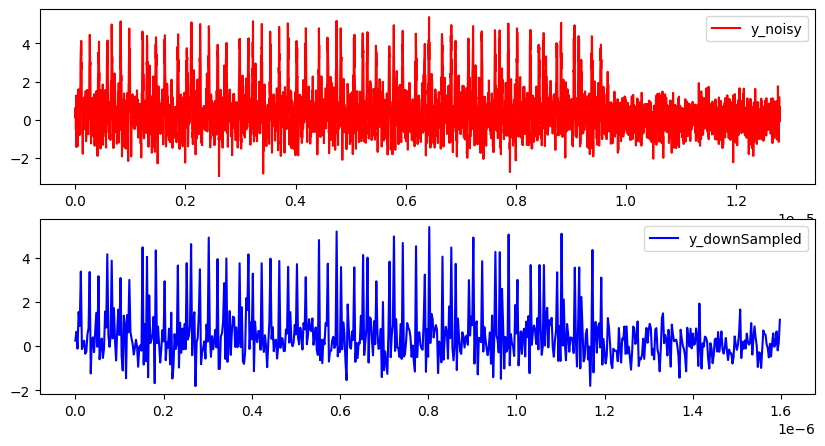

----------Datasetnew_clt_m1.pkl is generated!
Generating dataset 2 with mean=0, variance=2 and mean_c=2, variance_c=1


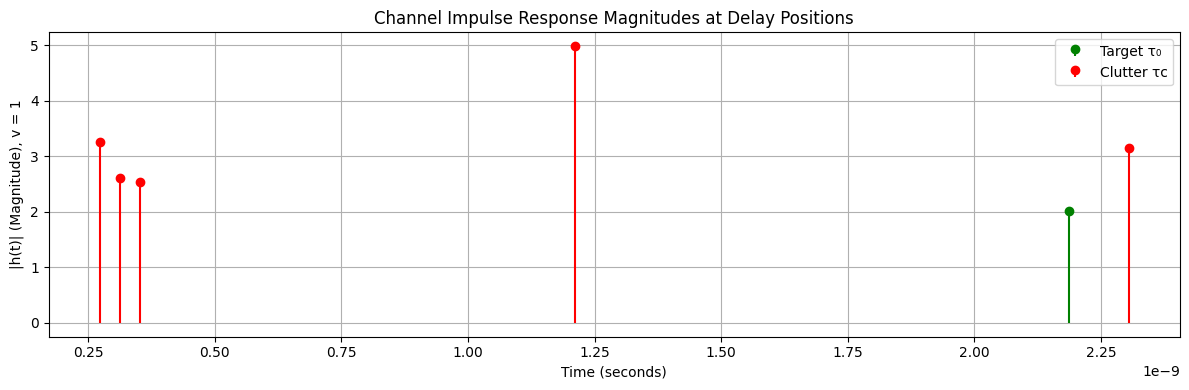

round# : 1  v :  1  tau: 3.5966069484646725e-09  min_delay_sec:  34 1.33 [2.3645104] [1.3754053303802574, 3.5335516204801305, 3.995174518424309, 3.9568394076512035, 2.1288982732489505]


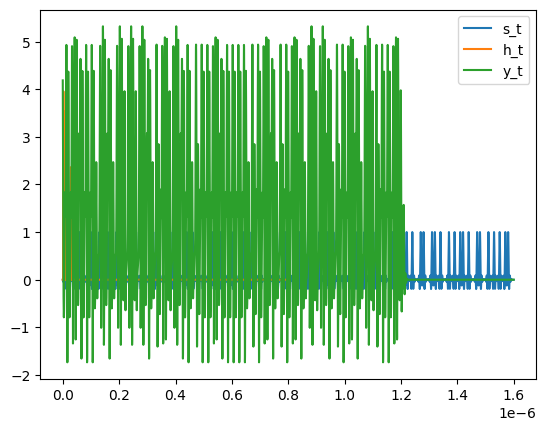

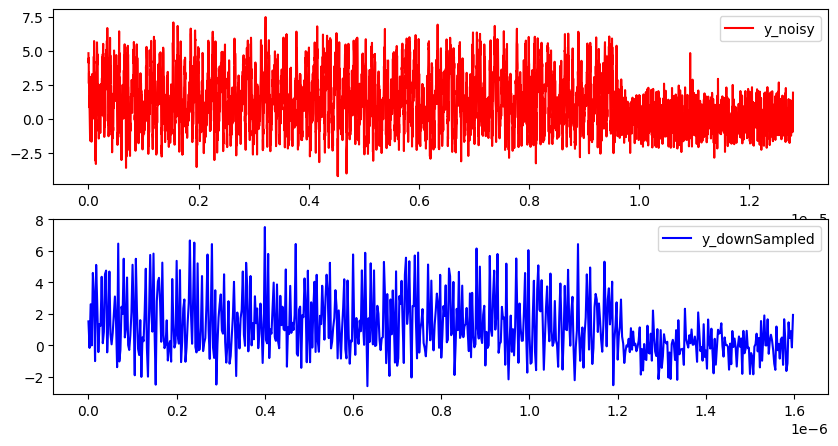

----------Datasetnew_clt_m2.pkl is generated!
Generating dataset 3 with mean=0, variance=2 and mean_c=3, variance_c=1


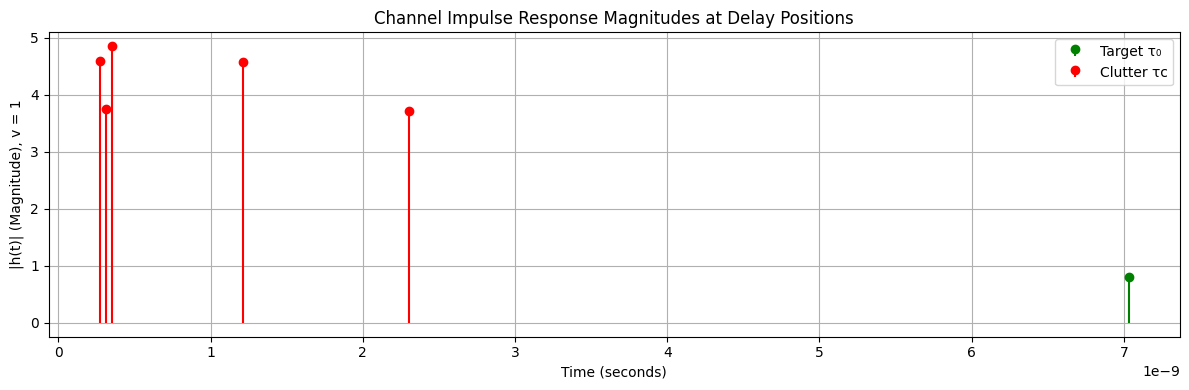

round# : 1  v :  1  tau: 7.021042256706826e-09  min_delay_sec:  121 4.73 [0.80710597] [3.7558140553924115, 4.567262744741616, 3.7189732440854892, 4.584046516240079, 4.85127086465165]


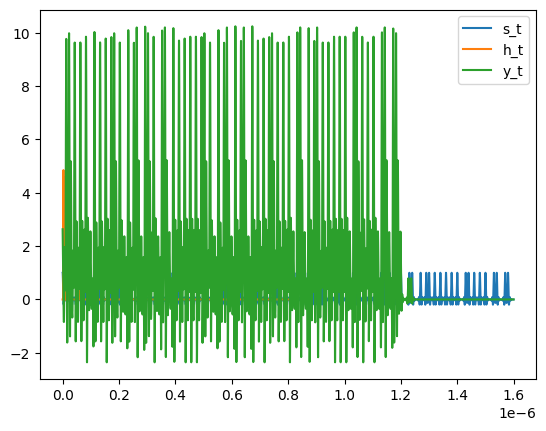

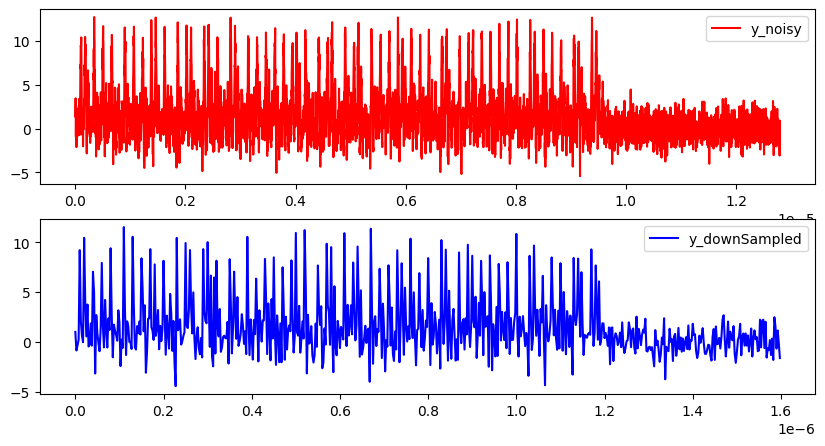

----------Datasetnew_clt_m3.pkl is generated!


In [9]:
# parameters initialization-----------------------------------------------------
import numpy as np
config_B = 400e6  # Bandwidth: 400 Mhz
config_L = 80     # number of slots
config_Lb = 4     # Bandwidth factor, in paper Lb ∈ [1,6]
config_Tc = 1 / config_B  # Chip/symbol time. Chip time = 2.5 ns
config_T = 2 * config_Lb * config_Tc  # Time slot duration: 2
config_beta = 0.25  # roll-off factor-(rrc) ???
config_t = np.linspace(
    0, config_L * config_T, config_L * 2 * config_Lb)  # Time vector: MaxTime: L * T = 80 * 1 = 80, No of samples: L * 2 * Lb = 80*2*2=320
config_x = np.random.binomial(n=1, p=0.5, size=config_L)  # np.random.randint(0, 2, L), x ∈ {0,1}
config_v = np.random.binomial(n=1, p=0.5)  # Target presence: Bernoulli(0.5)
config_upsample = 8

config_channel_duration = 1e-7  # 100 ns
config_channel_samples = int(config_channel_duration // (config_Tc / (config_upsample * 2 * config_Lb))) # 2559
config_resolution = config_Tc / (2 * config_Lb * config_upsample)  # ≈ 3.90625e-11 seconds, It is resolution of channel
config_sampling = config_Tc /config_upsample

config_Nc = 5  # number of clutters
config_sigma_0 = 2.0  # Variance (or power) of the target amplitude β0 ???
config_tau_0 = np.random.uniform(0, 4 * config_Tc, 1)  # target delay
config_tau_c = np.random.uniform(0, 4 * config_Tc, config_Nc)  # np.random.choice(np.arange(0, int(4 * Tc)+1), size=Nc, replace=False) #np.random.uniform(0, 4 * Tc, Nc)  # clutter delays uniformly distributed between 0 and 4Tc

config_k_c = 2  # Shape parameter for Weibull distribution, κ ∈ [0.25,2]
config_lambda_c = 1.0  # Scale parameter for Weibull distribution, λ ∈ (0,∞)  ???


# total input data size based on paper: 60000(train) + 10000(test) = 70000



#Create datasets----------------------------------------------------------------
import pickle
# import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import convolve
np.random.seed(42) #For having fixed values every time the code is run.


def generate_complex_gaussian(n, mean, variance):
    real_part = np.random.normal(mean, np.sqrt(variance / 2), n)
    imag_part = np.random.normal(mean, np.sqrt(variance / 2), n)
    return real_part + 1j * imag_part


def generate_s_t(t, T, L, x, Lb, Tc, beta):

    s_i = np.zeros(len(t), dtype=complex)

    # Loop in each time slot
    for l in range(len(x)):
        if x[l]:
            s_i[l * 2 * Lb + Lb] = 1.0
        else:
            s_i[l * 2 * Lb] = 1.0

    s_t_prime = np.zeros((len(s_i) * config_upsample), dtype=complex)
    s_t_prime[:: config_upsample] = s_i

    pulse_length = 101
    time = np.arange(pulse_length) - (pulse_length - 1) // 2
    Ts = config_upsample
    phi_t = (
        np.sinc(time / Ts)
        * np.cos(np.pi * beta * time / Ts)
        / (1 - (2 * beta * time / Ts) ** 2 + 1e-8)
    ).astype(complex)

    # plt.figure(1)
    # plt.stem(time, phi_t)
    # plt.grid()
    # plt.show()

    s_t = np.convolve(s_t_prime, phi_t, "same")

    # plt.figure()
    # plt.title("s(i)/s(t)")
    # plt.stem(Tc * np.arange(len(s_i)), s_i.real, label="s(i)", basefmt="b-")
    # plt.plot(
    #     (Tc / config_upsample) * np.arange(len(s_i) * config_upsample),
    #     s_t.real,
    #     "r",
    #     label="s(t)",
    # )
    # plt.legend(loc="upper right")
    # plt.show()

    return t, s_t


def channel_response(beta, Tc, v, sigma_0, tau_0, tau_c, Nc, beta_0, beta_c, r):
    import numpy as np
    global isChannelPloted

    h_t = np.zeros(config_channel_samples, dtype=complex)
    # print("h_t len: ", len(h_t)) #2559

    upsampled_time = np.arange(len(h_t)) * (Tc / (2 * config_Lb * config_upsample)) #channel_duration = 1e-7
    # print("upsampled_time len: ", len(upsampled_time)) #2559

    # generate the delays
    tau_0_dis = np.digitize(tau_0, upsampled_time) # find the index in upsampled_time that corresponds to the value of tau_0.
    tau_c_dis = np.digitize(tau_c, upsampled_time)
    # print("tau_c_dis: ", tau_c_dis)

    h_t[tau_0_dis] = v * beta_0
    h_t[tau_c_dis] = beta_c

    # h_t = np.convolve(h_t, phi_rx, "same")
    # plt.plot((Tc / config_upsample) * np.arange(len(h_t)), np.abs(h_t), label= "channel")
    # plt.show()


    # Compute minimum distance between target and clutters-------------
    distances = np.abs(tau_0_dis[0] - tau_c_dis)
    min_delay_sec = distances.min() * (config_resolution)
    # print(f"Distances between τ₀ and each τc (in samples): {distances}")
    # print(f"Minimum distance: {distances.min()} samples, Time: {distances.min() * (upsampled_time[1] - upsampled_time[0]):.2e} seconds")
    #----------------------------------------------------------------


    # Plot-------------------------
    if v == 1 and not isChannelPloted:
      isChannelPloted = True

      import numpy as np
      import matplotlib.pyplot as plt

      plt.figure(figsize=(12, 4))
      target_magnitude = np.abs(h_t[tau_0_dis])[0]
      clutter_magnitudes = np.abs(h_t[tau_c_dis])

      # Stem plot for tau_0_dis (Target Delay)
      plt.stem([upsampled_time[tau_0_dis[0]]], [target_magnitude], linefmt='g-', markerfmt='go', basefmt=" ", label='Target τ₀')

      # Stem plot for tau_c_dis (Clutter Delays)
      plt.stem(upsampled_time[tau_c_dis], clutter_magnitudes, linefmt='r-', markerfmt='ro', basefmt=" ", label='Clutter τc')

      # Plot aesthetics
      plt.xlabel('Time (seconds)')
      plt.ylabel(f'|h(t)| (Magnitude), v = {v}')
      plt.title('Channel Impulse Response Magnitudes at Delay Positions')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()


    # Prepare data for dataframe
    data_dict = {
        "v": v,
        "tau_0_dis": int(tau_0_dis[0]),
        "tau_c_dis": tau_c_dis.tolist(),
        "min_delay_sec": round(min_delay_sec * 1e9, 2),
        "min_distance": distances.min(),
        "tau_0": tau_0,
        "tau_c": tau_c.tolist() # list of complex numbers
    }

    return h_t, data_dict


def received_signal(s_t, h_t):

    y = convolve(s_t, h_t, mode="same")
    return y


def sample_received_signal(y, h, st):
    first_nonzero = np.argwhere(np.abs(h))[0][0]
    last_samples = y[-first_nonzero:]
    y = np.concatenate((y, last_samples))
    y_downsample = y[first_nonzero :: config_upsample]
    # plt.plot(np.abs(h))
    # plt.title(first_nonzero)
    # plt.show()

    # print(f"len(y):{len(y)}, y_downsample: {len(y_downsample)}, first_nonzero = {first_nonzero}") #len(y):5200, y_downsample: 640, first_nonzero = 80

    yl = y_downsample.reshape(config_L, 2*config_Lb)
    # print("yl(i) shape: ", yl.shape) #(80, 8)
    yl_mapped = complex_to_real_vector(yl)
    # print("yl_mapped shape: ", yl_mapped.shape) #(80, 16)


    xl = st[ :: config_upsample].reshape(config_L, 2*config_Lb)
    # print("xl(i) shape: ", xl.shape) #(80, 8)
    xl_mapped = complex_to_real_vector(xl)
    # print("xl_mapped shape: ", xl_mapped.shape) #(80, 16)

    return yl_mapped, xl_mapped


def complex_to_real_vector(yl):
    y_mapped=[]
    for row in yl:
        real_part = row.real
        imag_part = row.imag
        row_concat = np.concatenate((real_part,imag_part))

        y_mapped.append(row_concat)

    return np.array(y_mapped)


def create_noise(num_noise_samples, h_t):
    Eb = 1
    SNR = 10  # SNR is given 10 dB
    nonzero_h = h_t[h_t != 0]
    squared_norm_h = np.abs(nonzero_h) ** 2  #|h|^2
    average_squared_norm_h = np.mean(squared_norm_h)
    N0B = (average_squared_norm_h * Eb) / SNR
    # print(f"_____N0B: {N0B}")
    noise = np.random.normal(0, np.sqrt(N0B), num_noise_samples) + 1j * np.random.normal(0, np.sqrt(N0B), num_noise_samples)
    return noise


dataset_configs = [
    # {"mean_0": 0, "mean_c": 0, "variance_0": 1, "variance_c": 1},

    # {"mean_0": 0, "mean_c": 0, "variance_0": 2, "variance_c": 1},
    # {"mean_0": 1, "mean_c": 0, "variance_0": 2, "variance_c": 1},
    # {"mean_0": 2, "mean_c": 0, "variance_0": 2, "variance_c": 1},
    # {"mean_0": 3, "mean_c": 0, "variance_0": 2, "variance_c": 1},
    # {"mean_0": 0, "mean_c": 0, "variance_0": 5, "variance_c": 1},
    # {"mean_0": 0, "mean_c": 0, "variance_0": 10, "variance_c": 1},

    # {"mean_0": 0, "mean_c": 0, "variance_0": 2, "variance_c": 1},
    {"mean_0": 0, "mean_c": 1, "variance_0": 2, "variance_c": 1},
    {"mean_0": 0, "mean_c": 2, "variance_0": 2, "variance_c": 1},
    {"mean_0": 0, "mean_c": 3, "variance_0": 2, "variance_c": 1},
    # {"mean_0": 0, "mean_c": 0, "variance_0": 2, "variance_c": 5},
    # {"mean_0": 0, "mean_c": 0, "variance_0": 2, "variance_c": 10},
]

dataset_names= ["new_clt_m1.pkl", "new_clt_m2.pkl", "new_clt_m3.pkl"]


# dataset_names=["new_dt_m0v1.pkl", "new_dt_trg_v2.pkl", "new_dt_trg_m1.pkl", "new_dt_trg_m2.pkl", "new_dt_trg_m3.pkl", "new_dt_trg_v5.pkl", "new_dt_trg_v10.pkl",
#                 "new_dt_clt_v2.pkl", "new_dt_clt_m1.pkl", "new_dt_clt_m2.pkl", "new_dt_clt_m3.pkl", "new_dt_clt_v5.pkl", "new_dt_clt_v10.pkl",
#                 ]


#------------------main-----------------------------------------------------------------------------------------------------
num_round = 100000
all_datasets = []
beta_0_mags= 0

for config_idx, config in enumerate(dataset_configs):
    print(f"Generating dataset {config_idx+1} with mean={config['mean_0']}, variance={config['variance_0']} and mean_c={config['mean_c']}, variance_c={config['variance_c']}")

    # multiple_tuples_1 = []
    multiple_tuples_2 = []
    channel_info_list = []
    isChannelPloted = False

    for r in range(num_round):
        x = np.random.binomial(n=1, p=0.5, size=config_L)  # np.random.randint(0, 2, L), x ∈ {0,1}
        v = np.random.binomial(n=1, p=0.5)  # Target presence: Bernoulli(0.5)
        if v==1:
            tau_0 = np.random.uniform(0, 4 * config_Tc, 1)  # target delay
        else:
            tau_0 = np.array([0])

        tau_label = tau_0[0]

        # Create signals----------
        t, s_t = generate_s_t(
            config_t, config_T, config_L, x, config_Lb, config_Tc, config_beta
        )
        # print("length of s(t):", len(s_t)) #5120


        beta_0 = generate_complex_gaussian(1, mean=config["mean_0"], variance=config["variance_0"])
        beta_c = generate_complex_gaussian(config_Nc, mean=config["mean_c"], variance=config["variance_c"])
        if v == 1:
          beta_0_mags = np.abs(beta_0)
        beta_c_mags = np.abs(beta_c).tolist()
        # print("B0: ", beta_0)
        # print("Bc: ", beta_c)



        #Second channel---------------
        h2_t, data_dict  = channel_response(
            config_beta,
            config_Tc,
            v,
            config_sigma_0,
            tau_0,
            config_tau_c,
            config_Nc,
            beta_0,
            beta_c,
            r,
        )
        channel_info_list.append(data_dict)

        y2_t = received_signal(s_t, h2_t)
        # print("length of y(t):", len(y2_t)) # 5120

        # Add noise to y(t)--------
        z2 = create_noise(len(y2_t), h2_t)
        y2_noisy = y2_t + z2

        # Downsample the y1(t)------
        yl2, xl2 = sample_received_signal(y2_noisy, h2_t, s_t)
        # print("round# :", r, " v : ", v , " tau:", tau_label)
        multiple_tuples_2.append((yl2, xl2, v, tau_label, data_dict["min_distance"], data_dict["min_delay_sec"], beta_0_mags, beta_c_mags))



        # Print one sample
        if r == 1:
            print("round# :", r, " v : ", v , " tau:", tau_label, " min_delay_sec: ", data_dict["min_distance"], data_dict["min_delay_sec"], beta_0_mags, beta_c_mags)
            plt.plot((config_Tc / config_upsample) * np.arange(len(s_t)), s_t.real, label = "s_t")
            plt.plot((config_Tc / config_upsample) * np.arange(len(h2_t)), np.abs(h2_t), label="h_t")
            plt.plot((config_Tc / config_upsample) * np.arange(len(y2_t)), y2_t.real, label="y_t")
            plt.legend()
            plt.show()

            plt.figure(figsize=(10, 5))
            plt.subplot(2,1,1)
            plt.plot(config_Tc * np.arange(len(y2_noisy)), y2_noisy.real, label="y_noisy", color='r')
            plt.legend()
            plt.subplot(2,1,2)
            plt.plot(config_Tc * np.arange(len(yl2[:, :8].real.flatten())), yl2[:, :8].real.flatten(), label="y_downSampled", color='b')
            plt.legend()
            plt.show()


    # Store the dataset in the list
    dataset_dict = {
        "config": config,
        "data": multiple_tuples_2,
        "channel_info": channel_info_list,
    }
    all_datasets.append(dataset_dict)

    #Save Generated Dataset
    fileName = "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/vt=2-vc=1/" + dataset_names[config_idx]
    with open(fileName, "wb") as f:
        pickle.dump(multiple_tuples_2, f)

    print(f"----------Dataset{dataset_names[config_idx]} is generated!")



In [ ]:
#Save Generated Dataset

for config_idx, config in enumerate(dataset_configs):
  fileName = "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/cluster/" + dataset_names[config_idx]
  with open(fileName, "wb") as f:
      pickle.dump(multiple_tuples_2, f)

  print(f"----------Dataset{dataset_names[config_idx]} is generated!")

----------Datasetnew_dt_clt_v2.pkl is generated!
----------Datasetnew_dt_clt_v5.pkl is generated!
----------Datasetnew_dt_clt_v10.pkl is generated!


In [ ]:
import plotly.graph_objects as go
import pandas as pd

print(f"Total datasets loaded: {len(all_datasets)}")



for idx, dataset in enumerate(all_datasets):

  df = pd.DataFrame(dataset["channel_info"])
  multiple_tuples_2 = dataset["data"]
  print(f"dataset_{idx} _________:")


  threshold = 10

  # # Distribution Of Minimum Distances (Τ₀ Vs Τc)
  # plt.figure(figsize=(8,5))
  # plt.hist(df["min_distance"], bins=30, color='skyblue', edgecolor='black')
  # plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
  # plt.title("Distribution of Minimum Distances (τ₀ vs τc)")
  # plt.xlabel("Minimum Distance (samples)")
  # plt.ylabel("Frequency")
  # plt.legend()
  # plt.grid(True)
  # plt.show()

  # Plot 1: Histogram
  fig_hist = go.Figure()
  fig_hist.add_trace(go.Histogram(
      x=df["min_distance"],
      nbinsx=30,marker=dict(color='skyblue',line=dict(color='black', width=1)),
      name='Min Distance'))
  # Threshold Line
  fig_hist.add_shape(type='line', x0=threshold, y0=0, x1=threshold, y1=df["min_distance"].value_counts().max(), line=dict(color='red', dash='dash'))
  fig_hist.update_layout(title="Distribution of Minimum Distances (τ₀ vs τc)",
      xaxis=dict(title="Minimum Distance (samples)", showgrid=True, gridcolor='white', # zeroline=False
                ),
      yaxis=dict(title="Frequency", showgrid=True,  gridcolor='white', # zeroline=False), # plot_bgcolor='white', showlegend=False
  ))
  fig_hist.show()

  # # Plot: Minimum Distance Over Samples
  # plt.figure(figsize=(12, 5))
  # plt.plot(df["min_distance"][0:1000], marker='o', linestyle='-', label="Min Distance")
  # plt.xlabel("Sample Index")
  # plt.ylabel("Minimum Distance (samples)")
  # plt.title("Minimum Distance between τ₀ and τc over Samples")
  # plt.grid(True)
  # plt.legend()
  # plt.tight_layout()
  # plt.show()

  # Plot 2: Line Plot
  fig_line = go.Figure()
  fig_line.add_trace(go.Scatter(y=df["min_distance"][0:1000], mode='lines+markers', name='Min Distance', line=dict(color='blue')))
  fig_line.update_layout(title="Minimum Distance between τ₀ and τc over Samples", xaxis_title="Sample Index", yaxis_title="Minimum Distance (samples)", showlegend=False)
  fig_line.show()


  #plot dataset----
  y_test2, x_test2, v_test2, tau, distance, delay, b0, bc = multiple_tuples_2[3]
  y_test_real2 = y_test2[:, :8].real.flatten()
  x_test_real2 = x_test2[:, :8].flatten()

  fig = go.Figure()
  fig.add_trace(go.Scatter(y = y_test_real2, mode='lines', name="y"))
  # # Stem plot for `x_test_real`
  # fig.add_trace(go.Scatter(y=x_test_real2, mode='markers', marker=dict(color='red', size=8), name="x"))
  fig.update_layout(title=f"multiple_tuples_Tau, v = {v_test2}",
                    xaxis_title="Index",
                    yaxis_title="Value",
                    hovermode="x unified")
  fig.show()

  # Extract |β₀| and |βc| from data
  beta_0_mags_flat = [val for t in multiple_tuples_2 if t[2] == 1 for val in t[6]]
  beta_c_mags_flat = [val for t in multiple_tuples_2 for val in t[7]]


  plt.figure(figsize=(12, 5))
  # Plot |β₀| distribution
  plt.subplot(1, 2, 1)
  plt.hist(beta_0_mags_flat, bins=50, alpha=0.7, color='green', edgecolor='black')
  plt.title(f"Distribution of |β₀| mean={dataset_configs[idx]['mean_0']}, variance={dataset_configs[idx]['variance_0']}")
  plt.xlabel("Magnitude")
  plt.ylabel("Frequency")
  plt.grid(True)

  # Plot |βc| distribution
  plt.subplot(1, 2, 2)
  plt.hist(beta_c_mags_flat, bins=50, alpha=0.7, color='red', edgecolor='black')
  plt.title(f"Distribution of |βc| mean_c={dataset_configs[idx]['mean_c']}, variance_c={dataset_configs[idx]['variance_c']}")
  plt.xlabel("Magnitude")
  plt.ylabel("Frequency")
  plt.grid(True)

  plt.tight_layout()
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/dataset17_Tau_sigmac=10.pkl", "wb") as f:
    pickle.dump(multiple_tuples_2, f)

print("Dataset_Tau is generated!")

Dataset6_Tau is generated!


In [ ]:
import plotly.graph_objects as go
import pickle

#Load datasets and show on sampel
# with open("/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/dataset5.pkl", "rb") as f:
#     multiple_tuples_1 = pickle.load(f)

# #plot dataset----
# y_test, x_test, v_test = multiple_tuples_1[3]
# y_test_real = y_test[:, :8].real.flatten()
# x_test_real = x_test[:, :8].flatten()

# fig = go.Figure()
# fig.add_trace(go.Scatter(y = y_test_real, mode='lines', name="y"))
# # # Stem plot for `x_test_real`
# # fig.add_trace(go.Scatter(y=x_test_real, mode='markers', marker=dict(color='red', size=8), name="x"))
# fig.update_layout(title=f"multiple_tuples, v = {v_test}",
#                   xaxis_title="Index",
#                   yaxis_title="Value",
#                   hovermode="x unified")
# fig.show()

# with open("/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/dataset12_Tau_mc=1.pkl", "rb") as f:
#     multiple_tuples_2 = pickle.load(f)


#plot dataset----
y_test2, x_test2, v_test2,_ = multiple_tuples_2[3]
y_test_real2 = y_test2[:, :8].real.flatten()
x_test_real2 = x_test2[:, :8].flatten()

fig = go.Figure()
fig.add_trace(go.Scatter(y = y_test_real2, mode='lines', name="y"))
# # Stem plot for `x_test_real`
# fig.add_trace(go.Scatter(y=x_test_real2, mode='markers', marker=dict(color='red', size=8), name="x"))
fig.update_layout(title=f"multiple_tuples_Tau, v = {v_test2}",
                  xaxis_title="Index",
                  yaxis_title="Value",
                  hovermode="x unified")
fig.show()




# Class distribution
# v_data1 = [sample[2] for sample in multiple_tuples_1]
v_data2 = [sample[2] for sample in multiple_tuples_2]

num_ones = sum(v_data2)  # Counts all 1s
num_zeros = len(v_data2) - num_ones  # Remaining are 0s

print(f"Number of 0s: {num_zeros}")
print(f"Number of 1s: {num_ones}")

Number of 0s: 50101
Number of 1s: 49899


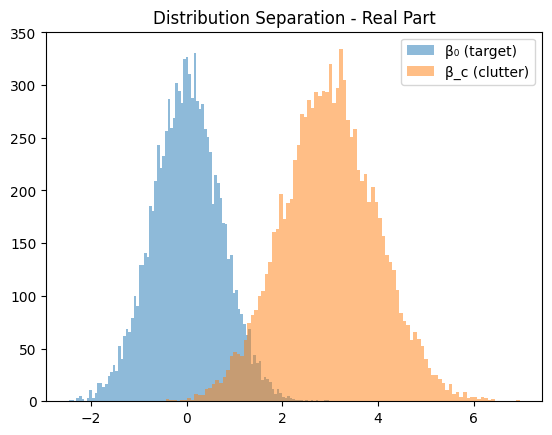

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_complex_gaussian(n, mean, variance):
    real_part = np.random.normal(mean, np.sqrt(variance / 2), n)
    imag_part = np.random.normal(mean, np.sqrt(variance / 2), n)
    return real_part + 1j * imag_part


beta_0_samples = generate_complex_gaussian(10000, mean=0, variance=1)
beta_c_samples = generate_complex_gaussian(10000, mean=3, variance=2)

plt.hist(np.real(beta_0_samples), bins=100, alpha=0.5, label="β₀ (target)")
plt.hist(np.real(beta_c_samples), bins=100, alpha=0.5, label="β_c (clutter)")
plt.legend()
plt.title("Distribution Separation - Real Part")
plt.show()
